# 12 Root Finding

An important tool in the computational tool box is to find roots of equations for which no closed form solutions exist:

We want to find the roots $x_0$ of

$$
f(x_0) = 0
$$

## Problem: Projectile range 
The equations of motion for the projectile with linear air resistance (see *12 ODE applications*) can be solved exactly.

As a reminder: the linear drag force is
$$
\mathbf{F}_1 = -b_1 \mathbf{v}\\
b := \frac{b_1}{m}
$$

Equations of motion with force due to gravity $\mathbf{g} = -g \hat{\mathbf{e}}_y$

\begin{align}
\frac{d\mathbf{r}}{dt} &= \mathbf{v}\\
\frac{d\mathbf{v}}{dt} &= - g \hat{\mathbf{e}}_y -b \mathbf{v} 
\end{align}

### Analytical solution of the equations of motion
(Following Wang Ch 3.3.2)

Solve $x$ component of the velocity 

$$
\frac{dv_x}{dt} = -b v_x
$$

by integration:

$$
v_x(t) = v_{0x} \exp(-bt)
$$

The drag force reduces the forward velocity to 0.

Integrate again to get the $x(t)$ component

$$
x(t) = x_0 + \frac{v_{0x}}{b} \left[1 - \exp(-bt)\right]
$$

Integrating the $y$ component of the velocity

$$
\frac{dv_y}{dt} = -g - b v_y
$$

gives

$$
v_y = \left(v_{0y} + \frac{g}{b}\right) \exp(-bt) - \frac{g}{b}
$$

and integrating again

$$
y(t) = y_0 + \frac{v_{0y} + \frac{g}{b}}{b} \left[1 - \exp(-bt)\right] - \frac{g}{b} t
$$

(Note: This shows immediately that the *terminal velocity* is

$$
\lim_{t\rightarrow\infty} v_y(t) = - \frac{g}{b},
$$

i.e., the force of gravity is balanced by the drag force.)

#### Analytical trajectory 

To obtain the **trajectory $y(x)$** eliminate time (and for convenience, using the origin as the initial starting point, $x_0 = 0$ and $y_0 = 0$. Solve $x(t)$ for $t$

$$
t = -\frac{1}{b} \ln \left(1 - \frac{bx}{v_{0x}}\right)
$$

and insert into $y(t)$:

$$
y(x) = \frac{x}{v_{0x}} \left( v_{0y} + \frac{g}{b} \right) + \frac{g}{b^2} \ln \left(1 - \frac{bx}{v_{0x}}\right)
$$

#### Plot 

Plot the analytical solution for $\theta = 30^\circ$ and $v_0 = 100$~m/s.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
def y_lindrag(x, v0, b1=0.2, g=9.81, m=0.5):
    b = b1/m
    v0x, v0y = v0
    return x/v0x * (v0y + g/b) + g/(b*b) * np.log(1 - b*x/v0x)

def initial_v(v, theta):
    x = np.deg2rad(theta)
    return v * np.array([np.cos(x), np.sin(x)])

The analytical function drops *very* rapidly towards the end ($> 42$ m – found by manual trial-and-error plotting...) so in order to nicely plot the function we use a fairly coarse sampling of points along $x$ for the range $0 \le x < 42$ and very fine sampling for the last 2 m ($42 \le x < 45$):

In [27]:
X = np.concatenate([np.linspace(0, 42, 100), np.linspace(42, 45, 10000)])

Evaluate the function for all $x$ values:

In [28]:
Y = y_lindrag(X, initial_v(100, 30), b1=1)

/Users/oliver/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in log


(The warning can be ignored, it just means that some of our `X` values were not approriate and outside the range of validity – when the argument of the logarithm becomes ≤0).

To indicate the ground we also plot a dashed black line: note that the analytical solution goes below the dashed line.

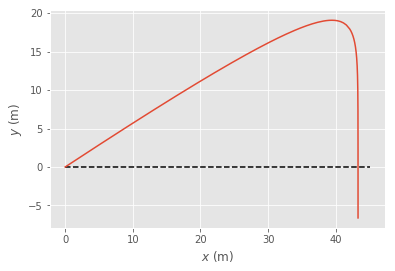

In [33]:
plt.plot(X, Y)
plt.xlabel("$x$ (m)")
plt.ylabel("$y$ (m)")
plt.hlines([0], X[0], X[-1], colors="k", linestyles="--");

Compare to the numerical solution (from 12 ODE Applications):

In [34]:
import ode

def simulate(v0, h=0.01, b1=0.2, g=9.81, m=0.5):
    def f(t, y):
        # y = [x, y, vx, vy]
        return np.array([y[2], y[3], -b1/m * y[2], -g - b1/m * y[3]])

    vx, vy = v0
    t = 0
    positions = []
    y = np.array([0, 0, vx, vy], dtype=np.float64)
    
    while y[1] >= 0:
        positions.append([t, y[0], y[1]])  # record t, x and y
        y[:] = ode.rk4(y, f, t, h)
        t += h
        
    return np.array(positions)

In [35]:
r = simulate(initial_v(100, 30), h=0.01, b1=1)

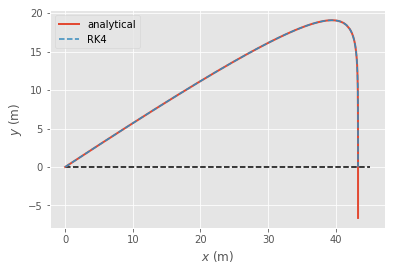

In [37]:
plt.plot(X, Y, lw=2, label="analytical")
plt.plot(r[:, 1], r[:, 2], '--', label="RK4")
plt.legend(loc="best")
plt.xlabel("$x$ (m)"); plt.ylabel("$y$ (m)")
plt.hlines([0], X[0], X[-1], colors="k", linestyles="--");

The RK4 solution tracks the analytical solution perfectly (and we also programmed it to not go below ground...)

### Predict the range $R$
How far does the ball or projectile fly, i.e., that value $x=R$ where $y(R) = 0$:

$$
\frac{R}{v_{0x}} \left( v_{0y} + \frac{g}{b} \right) + \frac{g}{b^2} \ln \left(1 - \frac{bR}{v_{0x}}\right) = 0
$$

This *transcendental equation* can not be solved in terms of elementary functions.

Use a **root finding** algorithm.

## Root-finding with the Bisection algorithm
**Bisection** is the simplest (but very robust) root finding algorithm that uses trial-and-error:

* bracket the root
* refine the brackets
* see [12_Root-finding-algorithms (PDF)](12_Root-finding-algorithms.pdf)

More specifically
1. determine a bracket that contains the root: $x_{-} < x_0 < x_{+}$
2. cut bracket in half: $x' = \frac{1}{2}(x_{+} + x_{-})$
3. determine in which half the root lies: $f(x_{-}) f(x') < 0$ then the root lies in the left half, otherwise the right half.
4. repeat until $|f(x)| < \epsilon$.

### Implementation of Bisection

- Test that the initial bracket contains a root; if not, return `None` (and possibly print a warning).
- If either of the bracket points is a root then return the bracket point.
- Allow `Nmax` iterations or until the convergence criterion `eps` is reached.
- Bonus: print a message if no root was found after `Nmax` iterations, but print the best guess and the error (but return `None`).


In [38]:
def bisection(f, xminus, xplus, Nmax=100, eps=1e-14):
    fa, fb = f(xminus), f(xplus)
    if (fa*fb) > 0:
        print("bisect: Initial bracket [{0}, {1}] "
              "does not contain a single root".format(xminus, xplus))
        return None
    if np.abs(fa) < eps:
        return xminus
    if np.abs(fb) < eps:
        return xplus
    
    for iteration in range(Nmax):
        x = (xplus + xminus)/2
        fx = f(x)
        if f(xplus) * fx > 0:
            # root is not between xplus and x
            xplus = x
        else:
            xminus = x
        if np.abs(fx) < eps:
            break
    else:
        print("bisect: no root found after {0} iterations (eps={1}); "
              "best guess is {2} with error {3}".format(Nmax, eps, x, fx))
        x = None
    return x

### Finding the range with the bisection algorithm

Define the trial function `f`.

Note that our `y_lindrag()` function depends on `x` **and** `v` but `bisect()` only accepts functions `f` that depend on a *single variable*, $f(x)$. We therefore have to wrap `y_lindrag(x, v)` into a function `f(x)` that sets `v` already to a value *outside* the function: [Python's scoping rules](https://stackoverflow.com/questions/291978/short-description-of-the-scoping-rules#292502) say that inside the function `f(x)`, the variable `x` has the value assigned to the argument of `f(x)` but any other variables such as `v` or `b1`, which were *not defined inside `f`*, will get the value that they had *outside `f`* in the *enclosing code*. 

In [39]:
v = initial_v(100, 30)

def f(x):
    return y_lindrag(x, v, b1=b1)

The initial bracket is a little bit difficult for this function: choose the right bracket near the point where the argument of the logarithm becomes 0 (which is actually the maximum $x$ value $\lim_{t\rightarrow +\infty} x(t) = \frac{v_{0x}}{b}$):

$$
x_{+} = \frac{v_{0x}}{b} - \epsilon
$$

In [40]:
b1 = 1.
m = 0.5
b = b1/m
bisection(f, 0.1, v[0]/b - 1e-12, eps=1e-6)

43.300674233470772

Note that this solution is *not* the maximum value $\lim_{t\rightarrow +\infty} x(t) = \frac{v_{0x}}{b}$:

In [41]:
v[0]/b

43.301270189221938

### Find the range as a function of the initial angle 

In [42]:
b1 = 1.
m = 0.5
b = b1/m
v0 = 100
u = []
for theta in np.arange(1, 90):
    v = initial_v(v0, theta)
    def f(x):
        return y_lindrag(x, v, b1=b1)
    R = bisection(f, 0.1, v[0]/b - 1e-16, eps=1e-5)
    if R is not None:
        u.append((theta, R))
u = np.array(u)

/Users/oliver/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log


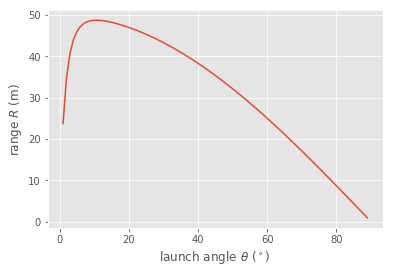

In [44]:
plt.plot(u[:, 0], u[:, 1])
plt.xlabel(r"launch angle $\theta$ ($^\circ$)")
plt.ylabel(r"range $R$ (m)");

Write a function `find_range()` to calculate the range for a given initial velocity $v_0$ and plot $R(\theta)$ for $10\,\text{m/s} ≤ v_0 ≤ 100\,\text{m/s}$.

In [45]:
def find_range(v0, b1=1, m=0.5):
    b = b1/m
    u = []
    for theta in np.arange(1, 90):
        v = initial_v(v0, theta)
        def f(x):
            return y_lindrag(x, v, b1=b1)
        R = bisection(f, 0.1, v[0]/b - 1e-16, eps=1e-5)
        if R is not None:
            u.append((theta, R))
    return np.array(u)

bisect: no root found after 100 iterations (eps=1e-05); best guess is 0.08726203218641801 with error nan


/Users/oliver/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log
/Users/oliver/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in log
/Users/oliver/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in absolute
/Users/oliver/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in absolute


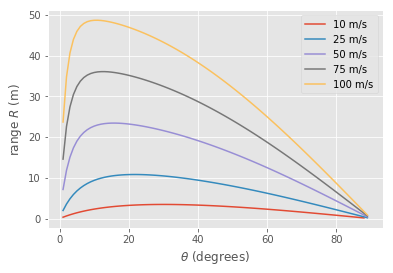

In [46]:
for v0 in (10, 25, 50, 75, 100):
    u = find_range(v0)
    plt.plot(u[:, 0], u[:, 1], label="{} m/s".format(v0))
plt.legend(loc="best")
plt.xlabel(r"$\theta$ (degrees)")
plt.ylabel(r"range $R$ (m)")

As a bonus, find the dependence of the *optimum launch angle* on the initial velocity, i.e., that angle that leads to the largest range:

In [48]:
np.argmax(u[:, 1])

10

/Users/oliver/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log
/Users/oliver/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in log
/Users/oliver/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in absolute
/Users/oliver/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in absolute


bisect: Initial bracket [0.1, 2.499619237890978] does not contain a single root
bisect: no root found after 100 iterations (eps=1e-05); best guess is 0.08724874175625272 with error nan
bisect: no root found after 100 iterations (eps=1e-05); best guess is 0.043631016093209005 with error nan
bisect: Initial bracket [0.1, 0.10399344977007888] does not contain a single root
bisect: no root found after 100 iterations (eps=1e-05); best guess is 0.052004645444430925 with error -inf
bisect: no root found after 100 iterations (eps=1e-05); best guess is 0.06037827479565286 with error nan
bisect: no root found after 100 iterations (eps=1e-05); best guess is 0.06875190414687479 with error nan
bisect: no root found after 100 iterations (eps=1e-05); best guess is 0.0771255334980967 with error -inf
bisect: no root found after 100 iterations (eps=1e-05); best guess is 0.08549916284931863 with error -inf
bisect: no root found after 100 iterations (eps=1e-05); best guess is 0.09387279220054057 with erro

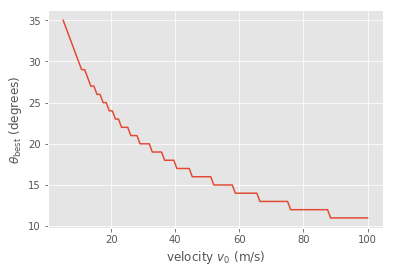

In [50]:
velocities = np.linspace(5, 100, 100)
results = []  # (v0, theta_opt)
for v0 in velocities:
    u = find_range(v0)
    thetas, ranges = u.transpose()
    # find index for the largest range and pull corresponding theta
    theta_opt = thetas[np.argmax(ranges)]
    results.append((v0, theta_opt))
results = np.array(results)

plt.plot(results[:, 0], results[:, 1]) 
plt.xlabel(r"velocity $v_0$ (m/s)")
plt.ylabel(r"$\theta_\mathrm{best}$ (degrees)")

The launch angle decreases with the velocity.

The steps in the graph are an artifact of choosing to only calculate the trajectories for integer angles (see `for theta in np.arange(1, 90)` in `find_range()`).

## Newton-Raphson algorithm
(see derivation in class and in the PDF or [Newton's Method](http://mathworld.wolfram.com/NewtonsMethod.html) on MathWorld)


### Activity: Implement Newton-Raphson
1. Implement the Newton-Raphson algorithm
2. Test with $g(x)$.

   $$
   g(x) = 2 \cos x - x
   $$
   
3. Bonus: test performance of `newton_raphson()` against `bisection()`.

In [51]:
def g(x):
    return 2*np.cos(x) - x

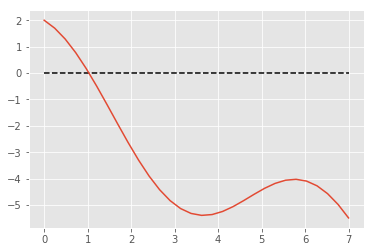

In [52]:
xvals = np.linspace(0, 7, 30)
plt.plot(xvals, np.zeros_like(xvals), 'k--')
plt.plot(xvals, g(xvals))

In [53]:
def newton_raphson(f, x, h=1e-3, Nmax=100, eps=1e-14):
    """Find root x0 so that f(x0)=0 with the Newton-Raphson algorithm"""
    for iteration in range(Nmax):
        fx = f(x)
        if np.abs(fx) < eps:
            break
        df = (f(x + h/2) - f(x - h/2))/h
        Delta_x = -fx/df
        x += Delta_x
    else:
        print("Newton-Raphson: no root found after {0} iterations (eps={1}); "
              "best guess is {2} with error {3}".format(Nmax, eps, x, fx))
        x = None
    return x

In [54]:
x0 = newton_raphson(g, 2)
print(x0)

1.02986652932


In [55]:
g(x0)

6.6613381477509392e-16

But note that the algorithm only converges well near the root. With other values it might not converge at all:

In [56]:
newton_raphson(g, 3)

Newton-Raphson: no root found after 100 iterations (eps=1e-14); best guess is -9322690.425062027 with error 16607175.892541457


In [58]:
newton_raphson(g, 10)

1.0298665293222589

In [59]:
newton_raphson(g, 15)

Newton-Raphson: no root found after 100 iterations (eps=1e-14); best guess is 52.96931452309739 with error -117.5878129311007


Let's look how Newton-Raphson iterates: also return all intermediate $x$ values:

In [60]:
def newton_raphson_with_history(f, x, h=1e-3, Nmax=100, eps=1e-14):
    xvals = []
    for iteration in range(Nmax):
        fx = f(x)
        if np.abs(fx) < eps:
            break
        df = (f(x + h/2) - f(x - h/2))/h
        Delta_x = -fx/df
        x += Delta_x
        xvals.append(x)
    else:
        print("Newton-Raphson: no root found after {0} iterations (eps={1}); "
              "best guess is {2} with error {3}".format(Nmax, eps, x, fx))
        x = None
    return x, np.array(xvals)

In [61]:
x = {}

x0, xvals = newton_raphson_with_history(g, 1.5)
x[1.5] = xvals
print("root x0 = {} after {} iterations".format(x0, len(xvals)))

x0, xvals = newton_raphson_with_history(g, 5)
x[5] = xvals
print("root x0 = {} after {} iterations".format(x0, len(xvals)))

x0, xvals = newton_raphson_with_history(g, 10)
x[10] = xvals
print("root x0 = {} after {} iterations".format(x0, len(xvals)))

root x0 = 1.0298665293222589 after 4 iterations
root x0 = 1.0298665293222589 after 58 iterations
root x0 = 1.0298665293222589 after 21 iterations


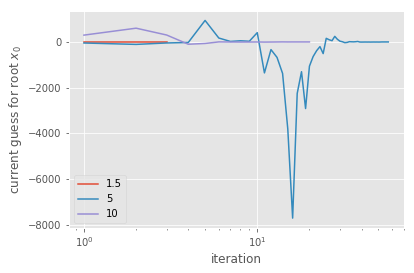

In [65]:
for xstart in sorted(x.keys()):
    plt.semilogx(x[xstart], label=str(xstart))
plt.legend(loc="best")
plt.xlabel("iteration")
plt.ylabel("current guess for root $x_0$")